In [2]:
#Importando las librerías necesarias
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import loadmat
import cv2

import seaborn as sns; sns.set()
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn import svm, datasets
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV

# EXPERIMENTACION 1:

# Generación del Data Set Binario

- Para poder generar el Data Set Binario, se necesita como requisito haber importado la librería open cv2.
- El proceso que se sigue es redimensionar las imagenes e ir recorriendo pixel a pixel.
- En caso de encontrarse un pixel blanco se imprimira 0 y en caso de uno negro será 1.

In [3]:
ruta = "C:/Users/Usuario/Documents/SEMINARIO DE INFORMATICA/NotebookTA"

In [4]:
def generarDataSet(directorio):
    archDataset = open(directorio+'/dataBin.txt', "w")
    listaCategorias = []
    cont = cantidadCategorias = 0
    archivo = open(directorio+'/lista_categorias.txt', "r")
    while (True):        
        nombreCategoria=archivo.readline()        
        if (nombreCategoria == "-1"): #caracter que nos indicara el fin del archivo
            break        
        posicion=nombreCategoria.find("\n")
        nombreCategoria = nombreCategoria[:posicion] #le quitamos el caracter de "\n"
        listaCategorias.insert(cont, nombreCategoria)  #insertamos el nombre en la lista
        cantidadCategorias = cantidadCategorias + 1
        print (listaCategorias[cont])
        cont = cont + 1   
           
    archivo.close()    
    #ya tenemos la lista con todos los nombres de las categorias
    #Ahora pasamos a recorrer cada imagen de cada categoria    
    aux = cont = 0
    imagxCateg = 80
    totalImagenes = imagxCateg*cantidadCategorias
    listaContornosImagenes = []
    listaMomentos = []
    while (aux<cantidadCategorias):        
        while (cont < totalImagenes):
            #extraemos una imagen
            ruta = directorio+'/Sketches/' + listaCategorias[aux]+"/" + str(cont+1) + ".png"
            print ("leemos la imagen en la ruta " + ruta) #ayuda)
            imagen = cv2.imread(ruta)            
            print ("leyendo la imagen "+ listaCategorias[aux]+"/" + str(cont+1) + ".png") #ayuda. nos dice que parche se esta leyendo
            
            #redimensionamos la imagen
            imgRedimensionada = cv2.resize(imagen, (150, 150)) 
            numFilas, numCols, canales = imgRedimensionada.shape
            cv2.imwrite(directorio+'/imagenes redimensionadas/'+ listaCategorias[aux]+"/" + str(cont+1) + ".png", imgRedimensionada)
            
            #recorremos los pixeles de la imagen
            for i in range(numFilas):
                for j in range(numCols):
                    (b,g,r) = imgRedimensionada[i, j]
                    if (int(b)==255 and int(g)==255 and int(r)==255): 
                        archDataset.write("0") #pixeles blancos
                    else:
                        archDataset.write("1") #pixeles negros                    
         
                    if ((i!=numFilas-1) or (j!=numCols-1)):
                        archDataset.write(" ")
 
            
            archDataset.write(" ")
            archDataset.write(str(aux))            
            archDataset.write("\n") #con el cambio de linea indicamos que pasaremos a la siguiente imagen. Es una imagen por linea
                     
            cont = cont + 1            
            if ((cont % 80) == 0):  # si ya se paso de la cantidad maxima de imagenes por categoria se pasa a la siguiente categoria
                aux = aux + 1
                break
            
    archDataset.close()

In [5]:
directorio = ruta
generarDataSet(directorio)

airplane
alarm clock
angel
ant
leemos la imagen en la ruta C:/Users/Usuario/Documents/SEMINARIO DE INFORMATICA/NotebookTA/Sketches/airplane/1.png
leyendo la imagen airplane/1.png
leemos la imagen en la ruta C:/Users/Usuario/Documents/SEMINARIO DE INFORMATICA/NotebookTA/Sketches/airplane/2.png
leyendo la imagen airplane/2.png
leemos la imagen en la ruta C:/Users/Usuario/Documents/SEMINARIO DE INFORMATICA/NotebookTA/Sketches/airplane/3.png
leyendo la imagen airplane/3.png
leemos la imagen en la ruta C:/Users/Usuario/Documents/SEMINARIO DE INFORMATICA/NotebookTA/Sketches/airplane/4.png
leyendo la imagen airplane/4.png
leemos la imagen en la ruta C:/Users/Usuario/Documents/SEMINARIO DE INFORMATICA/NotebookTA/Sketches/airplane/5.png
leyendo la imagen airplane/5.png
leemos la imagen en la ruta C:/Users/Usuario/Documents/SEMINARIO DE INFORMATICA/NotebookTA/Sketches/airplane/6.png
leyendo la imagen airplane/6.png
leemos la imagen en la ruta C:/Users/Usuario/Documents/SEMINARIO DE INFORMATICA/N

In [7]:
#Cargamos el data set binario
data = np.loadtxt('dataBin.txt')
print (data.shape)

(320, 22501)


# Experimentación con Redes Neuronales

In [8]:
y = np.c_[data[:, data.shape[1]-1]]
X = np.c_[data[:, 0:data.shape[1]-1]]

In [9]:
def sigmoid(z):
        return 1 / (1 + np.exp(-z))

In [10]:
def cost(theta, X, y, learningRate):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    first = np.multiply(-y, np.log(sigmoid(X * theta.T)))
    second = np.multiply((1 - y), np.log(1 - sigmoid(X * theta.T)))
    reg = (learningRate / 2 * len(X)) * np.sum(np.power(theta[:,1:theta.shape[1]], 2))
    return np.sum(first - second) / (len(X)) + reg

In [11]:
def gradient(theta, X, y, learningRate):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    
    parameters = int(theta.ravel().shape[1])
    error = sigmoid(X * theta.T) - y
    
    grad = ((X.T * error) / len(X)).T + ((learningRate / len(X)) * theta)
    
    # intercept gradient is not regularized
    grad[0, 0] = np.sum(np.multiply(error, X[:,0])) / len(X)
    
    return np.array(grad).ravel()

In [12]:
from scipy.optimize import minimize

def one_vs_all(X, y, num_labels, learning_rate):
    rows = X.shape[0]
    params = X.shape[1]
    
    # k X (n + 1) array for the parameters of each of the k classifiers
    all_theta = np.zeros((num_labels, params + 1))
    
    # insert a column of ones at the beginning for the intercept term
    X = np.insert(X, 0, values=np.ones(rows), axis=1)
    
    # labels are 1-indexed instead of 0-indexed
    for i in range(1, num_labels + 1):
        theta = np.zeros(params + 1)
        y_i = np.array([1 if label == i else 0 for label in y])
        y_i = np.reshape(y_i, (rows, 1))
        
        # minimize the objective function
        fmin = minimize(fun=cost, x0=theta, args=(X, y_i, learning_rate), method='TNC', jac=gradient)
        all_theta[i-1,:] = fmin.x
    
    return all_theta

In [13]:
rows = X.shape[0]
params = y.shape[1]

all_theta = np.zeros((10, params + 1))

X = np.insert(X, 0, values=np.ones(rows), axis=1)

theta = np.zeros(params + 1)

y_0 = np.array([1 if label == 0 else 0 for label in y])
y_0 = np.reshape(y_0, (rows, 1))

X.shape, y_0.shape, theta.shape, all_theta.shape

((320, 22501), (320, 1), (2,), (10, 2))

In [14]:
np.unique(y)

array([ 0.,  1.,  2.,  3.])

In [15]:
all_theta = one_vs_all(X, y, 4, 0.005)
all_theta

array([[-0.01011971, -0.01011934,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.06814115, -0.06814025,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.00665467,  0.00665498,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.08099699, -0.08099613,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [16]:
def predict_all(X, all_theta):
    rows = X.shape[0]
    params = X.shape[1]
    num_labels = all_theta.shape[0]
    
    # same as before, insert ones to match the shape
    X = np.insert(X, 0, values=np.ones(rows), axis=1)
    
    # convert to matrices
    X = np.matrix(X)
    all_theta = np.matrix(all_theta)
    
    # compute the class probability for each class on each training instance
    h = sigmoid(X * all_theta.T)
    
    # create array of the index with the maximum probability
    h_argmax = np.argmax(h, axis=1)
    
    # because our array was zero-indexed we need to add one for the true label prediction
    h_argmax = h_argmax + 1
    
    return h_argmax

In [17]:
y_pred = predict_all(X, all_theta)

#Se imprime el accuracy obtenido
correct = [1 if a == b else 0 for (a, b) in zip(y_pred, y)]
accuracy = (sum(map(int, correct)) / float(len(correct)))
print ('Accuracy using Binary Data Set = {0}%'.format(accuracy * 100))

Accuracy using Binary Data Set = 75.0%


# EXPERIMENTACION 2:

# Generación del Data Set empleando FindContours
- Para generar este data set, se ha utilizado la función FindContours de la librería opencv2
- Básicamente lo que se hace es generar una lista con los contornos de cada imagen.
- Cada contorno individualmente representa unas coordenadas (x,y)

In [18]:
def generarContornosExternosBDImagenes(direct):
    #ingresoYguardadoDeTrazos()
    #Creamos una lista que incluya los nombres de todas las categorias de las imagenes hechas a mano
    listaCategorias = [] 
    cont = cantidadCategorias = 0
    archivo = open(direct+'/lista_categorias.txt', "r")
    while (True):        
        nombreCategoria=archivo.readline()        
        if (nombreCategoria == "-1"): #caracter que nos indicara el fin del archivo
            break        
        posicion=nombreCategoria.find("\n")
        nombreCategoria = nombreCategoria[:posicion] #le quitamos el caracter de "\n"
        listaCategorias.insert(cont, nombreCategoria)  #insertamos el nombre en la lista
        cantidadCategorias = cantidadCategorias + 1
        print (listaCategorias[cont])
        cont = cont + 1   
           
    archivo.close()    
    #ya tenemos la lista con todos los nombres de las categorias
    #Ahora pasamos a recorrer cada imagen de cada categoria    
    aux = cont = 0
    imagxCateg = 80
    totalImagenes = imagxCateg*cantidadCategorias
    listaContornosImagenes = []
    listaMomentos = []
    while (aux<cantidadCategorias):        
        while (cont < totalImagenes):
            #extraemos una imagen
            ruta = direct+'/Sketches/' + listaCategorias[aux]+"/" + str(cont+1) + ".png"
            print ("leemos la imagen en la ruta " + ruta) #ayuda
            imagen = cv2.imread(ruta)            
            print ("leyendo la imagen "+ listaCategorias[aux]+"/" + str(cont+1) + ".png") #ayuda. nos dice que parche se esta leyendo
            
            imagen_gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
            thresh = cv2.bitwise_not(imagen_gris)
            thresh[thresh > 0] = 255
            contorno = np.zeros(imagen_gris.shape, dtype = "uint8")
            cnts,_=cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) #CHAIN_APPROX_SIMPLE  #RETR_LIST(para contornos internos y externos)  #RETR_TREE(para contornos externos)
            cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[0] 
                       
            print ("longitud del arreglo de contornos es ", len(cnts))            
            #procedemos a dibujar el contorno
            contorno = np.zeros(imagen_gris.shape, dtype = "uint8") #establecemos el lienzo negro. "imagen_gris.shape" nos inidica las dimensiones del lienzo            
            contorno = cv2.cvtColor(contorno,cv2.COLOR_GRAY2BGR) #pasamos la imagen a formato color y le asignamos valor BGR aleatorios para su contorno
            
            #cv2.imshow("imagen contorno", contorno) 
            #cv2.destroyAllWindows()
            cv2.drawContours(contorno, cnts, -1, (255, 255, 255), -1)
            #cv2.imshow("contornos detectados", contorno)
            #cv2.destroyAllWindows()
            cv2.imwrite(direct+'/contornos externos/'+listaCategorias[aux]+"/"+ str(cont+1) + ".png", contorno)
            
            cntDib = cnts
            listaContornosImagenes.insert(cont, cntDib)
            
            cont = cont + 1            
            if (cont % 80 == 0):  # si ya se paso de la cantidad maxima de imagenes por categoria se pasa a la siguiente categoria
                aux = aux + 1
                break
    
    return listaContornosImagenes

In [19]:
def generarContornosFiguras(direct):
    listaContFig = []
    ruta = direct
    #primero redimensionamos las imagenes de figuras geometricas a 1111x1111
    listaFiguras = np.array(['circulo','triangulo','rectangulo','cruz','cuadrado'])
    for i in range(len(listaFiguras)):
        nombFigura = listaFiguras[i]        
        imagen = cv2.imread(ruta+ "/figuras geometricas basicas/" + nombFigura + ".png")
        imgRedim = cv2.resize(imagen, (1111, 1111))
        cv2.imwrite(ruta+ "/figuras geometricas basicas redimensionadas/" + nombFigura + ".png", imgRedim)        
        #extraemos el contorno de cada figura geometrica
        imagen_gris = cv2.cvtColor(imgRedim, cv2.COLOR_BGR2GRAY)
        thresh = cv2.bitwise_not(imagen_gris)
        thresh[thresh > 0] = 255
        contorno = np.zeros(imagen_gris.shape, dtype = "uint8")
        cnts,_=cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) #CHAIN_APPROX_SIMPLE  #RETR_LIST(para contornos internos y externos)  #RETR_TREE(para contornos externos)
        cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[0] 
        
        print ("longitud del arreglo de contornos es ", len(cnts))            
        #procedemos a dibujar el contorno
        contorno = np.zeros(imagen_gris.shape, dtype = "uint8") #establecemos el lienzo negro. "imagen_gris.shape" nos inidica las dimensiones del lienzo            
        contorno = cv2.cvtColor(contorno,cv2.COLOR_GRAY2BGR) #pasamos la imagen a formato color y le asignamos valor BGR aleatorios para su contorno
            
        #cv2.imshow("imagen contorno", contorno) 
        #cv2.destroyAllWindows()
        cv2.drawContours(contorno, cnts, -1, (255, 255, 255), -1)
        #cv2.imshow("contornos detectados", contorno)
        #cv2.destroyAllWindows()
        cv2.imwrite(ruta+ "/contornos figuras geometricas/" +"/"+ nombFigura + ".png", contorno)
            
        cntDib = cnts
        listaContFig.insert(i, cntDib)
    
    return listaContFig

In [23]:
def compararContornos(listaContornosImagenes, listaContornosFiguras,direct):
    ruta = direct
    archivo = open(ruta + "/datasetFindContours.txt", "w")
    for i in range(len(listaContornosImagenes)):
        cntImg = listaContornosImagenes[i]
        for j in range(len(listaContornosFiguras)):
            cntFig = listaContornosFiguras[j]
            distancia = float(cv2.matchShapes(cntImg,cntFig,1,0.0))
            archivo.write(str(distancia))
            if (j!=(len(listaContornosFiguras)-1)):
                archivo.write(" ")
            else:
                archivo.write("\n")                
    
    archivo.close()

In [24]:
def generarDataSetFindContours(direct):
    listaContornosFiguras = []
    listaContornosFiguras = generarContornosFiguras(direct)
    listaContornosImagenes = []
    listaContornosImagenes = generarContornosExternosBDImagenes(direct)
    compararContornos(listaContornosImagenes, listaContornosFiguras,direct)

In [25]:
direct = ruta
generarDataSetFindContours(direct)

('longitud del arreglo de contornos es ', 3042)
('longitud del arreglo de contornos es ', 2387)
('longitud del arreglo de contornos es ', 2472)
('longitud del arreglo de contornos es ', 3624)
('longitud del arreglo de contornos es ', 4050)
airplane
alarm clock
angel
ant
leemos la imagen en la ruta C:/Users/Usuario/Documents/SEMINARIO DE INFORMATICA/NotebookTA/Sketches/airplane/1.png
leyendo la imagen airplane/1.png
('longitud del arreglo de contornos es ', 3022)
leemos la imagen en la ruta C:/Users/Usuario/Documents/SEMINARIO DE INFORMATICA/NotebookTA/Sketches/airplane/2.png
leyendo la imagen airplane/2.png
('longitud del arreglo de contornos es ', 4665)
leemos la imagen en la ruta C:/Users/Usuario/Documents/SEMINARIO DE INFORMATICA/NotebookTA/Sketches/airplane/3.png
leyendo la imagen airplane/3.png
('longitud del arreglo de contornos es ', 5892)
leemos la imagen en la ruta C:/Users/Usuario/Documents/SEMINARIO DE INFORMATICA/NotebookTA/Sketches/airplane/4.png
leyendo la imagen airplane

In [ ]:
#Al DataSetGenerado se le debe agregar una columna con el target

# Experimentación con Redes Neuronales

In [27]:
data = np.loadtxt('datasetFindContoursTarget.txt')
#print data.shape

y = np.c_[data[:, data.shape[1]-1]]
X = np.c_[data[:, 0:data.shape[1]-1]]

In [28]:
rows = X.shape[0]
params = y.shape[1]

all_theta = np.zeros((10, params + 1))

X = np.insert(X, 0, values=np.ones(rows), axis=1)

theta = np.zeros(params + 1)

y_0 = np.array([1 if label == 0 else 0 for label in y])
y_0 = np.reshape(y_0, (rows, 1))

X.shape, y_0.shape, theta.shape, all_theta.shape

((320, 6), (320, 1), (2,), (10, 2))

In [29]:
np.unique(y)

array([ 0.,  1.,  2.,  3.])

In [30]:
all_theta = one_vs_all(X, y, 4, 0.005)
all_theta

array([[-0.29042779, -0.29042731, -0.13603622, -0.01029812,  0.05804506,
         0.22360863, -0.13462387],
       [-0.22604433, -0.22604396,  0.00552706, -0.00562256,  0.0120409 ,
        -0.02105083,  0.00528037],
       [-0.26433646, -0.26433605,  0.0355737 ,  0.01065135,  0.05424411,
        -0.13259459,  0.03522591],
       [-0.48582442, -0.48582365, -0.00420121,  0.00062757,  0.07884266,
        -0.07208976, -0.003453  ]])

In [55]:
y_pred = predict_all(X, all_theta)

#print y_pred
correct = [1 if a == b else 0 for (a, b) in zip(y_pred, y)]
accuracy = (sum(map(int, correct)) / float(len(correct)))
print ('Accuracy using FindContours Data Set = {0}%'.format(accuracy * 100))

Accuracy using FindContours Data Set = 53.75%


# EXPERIMENTACION 3:

# Generación del Data Set empleando ShapeContext
- ShapeContext toma como input las característiscas más significativas de una imagen y emplea comeplejos cálculos matemáticos     como momentos de Hu.
- Estos cálculos arrojan un resultado entre 0 y 1 que representa qué tan parecida es una imagen con otra.
- Mientrás el valor se acerque más a 0, la similitud entre las imágenes será mayor.

In [ ]:
#Munkres.py

import copy

#!/usr/bin/env python
# -*- coding: iso-8859-1 -*-

# Documentation is intended to be processed by Epydoc.

"""
Introduction
============
The Munkres module provides an implementation of the Munkres algorithm
(also called the Hungarian algorithm or the Kuhn-Munkres algorithm),
useful for solving the Assignment Problem.
Assignment Problem
==================
Let *C* be an *n*\ x\ *n* matrix representing the costs of each of *n* workers
to perform any of *n* jobs. The assignment problem is to assign jobs to
workers in a way that minimizes the total cost. Since each worker can perform
only one job and each job can be assigned to only one worker the assignments
represent an independent set of the matrix *C*.
One way to generate the optimal set is to create all permutations of
the indexes necessary to traverse the matrix so that no row and column
are used more than once. For instance, given this matrix (expressed in
Python)::
    matrix = [[5, 9, 1],
              [10, 3, 2],
              [8, 7, 4]]
You could use this code to generate the traversal indexes::
    def permute(a, results):
        if len(a) == 1:
            results.insert(len(results), a)
        else:
            for i in xrange(0, len(a)):
                element = a[i]
                a_copy = [a[j] for j in xrange(0, len(a)) if j != i]
                subresults = []
                permute(a_copy, subresults)
                for subresult in subresults:
                    result = [element] + subresult
                    results.insert(len(results), result)
    results = []
    permute(range(len(matrix)), results) # [0, 1, 2] for a 3x3 matrix
After the call to permute(), the results matrix would look like this::
    [[0, 1, 2],
     [0, 2, 1],
     [1, 0, 2],
     [1, 2, 0],
     [2, 0, 1],
     [2, 1, 0]]
You could then use that index matrix to loop over the original cost matrix
and calculate the smallest cost of the combinations::
    n = len(matrix)
    minval = sys.maxint
    for row in xrange(n):
        cost = 0
        for col in xrange(n):
            cost += matrix[row][col]
        minval = min(cost, minval)
    print minval
While this approach works fine for small matrices, it does not scale. It
executes in O(*n*!) time: Calculating the permutations for an *n*\ x\ *n*
matrix requires *n*! operations. For a 12x12 matrix, that's 479,001,600
traversals. Even if you could manage to perform each traversal in just one
millisecond, it would still take more than 133 hours to perform the entire
traversal. A 20x20 matrix would take 2,432,902,008,176,640,000 operations. At
an optimistic millisecond per operation, that's more than 77 million years.
The Munkres algorithm runs in O(*n*\ ^3) time, rather than O(*n*!). This
package provides an implementation of that algorithm.
This version is based on
http://www.public.iastate.edu/~ddoty/HungarianAlgorithm.html.
This version was written for Python by Brian Clapper from the (Ada) algorithm
at the above web site. (The ``Algorithm::Munkres`` Perl version, in CPAN, was
clearly adapted from the same web site.)
Usage
=====
Construct a Munkres object::
    from munkres import Munkres
    m = Munkres()
Then use it to compute the lowest cost assignment from a cost matrix. Here's
a sample program::
    from munkres import Munkres, print_matrix
    matrix = [[5, 9, 1],
              [10, 3, 2],
              [8, 7, 4]]
    m = Munkres()
    indexes = m.compute(matrix)
    print_matrix(matrix, msg='Lowest cost through this matrix:')
    total = 0
    for row, column in indexes:
        value = matrix[row][column]
        total += value
        print '(%d, %d) -> %d' % (row, column, value)
    print 'total cost: %d' % total
Running that program produces::
    Lowest cost through this matrix:
    [5, 9, 1]
    [10, 3, 2]
    [8, 7, 4]
    (0, 0) -> 5
    (1, 1) -> 3
    (2, 2) -> 4
    total cost=12
The instantiated Munkres object can be used multiple times on different
matrices.
Non-square Cost Matrices
========================
The Munkres algorithm assumes that the cost matrix is square. However, it's
possible to use a rectangular matrix if you first pad it with 0 values to make
it square. This module automatically pads rectangular cost matrices to make
them square.
Notes:
- The module operates on a *copy* of the caller's matrix, so any padding will
  not be seen by the caller.
- The cost matrix must be rectangular or square. An irregular matrix will
  *not* work.
Calculating Profit, Rather than Cost
====================================
The cost matrix is just that: A cost matrix. The Munkres algorithm finds
the combination of elements (one from each row and column) that results in
the smallest cost. It's also possible to use the algorithm to maximize
profit. To do that, however, you have to convert your profit matrix to a
cost matrix. The simplest way to do that is to subtract all elements from a
large value. For example::
    from munkres import Munkres, print_matrix
    matrix = [[5, 9, 1],
              [10, 3, 2],
              [8, 7, 4]]
    cost_matrix = []
    for row in matrix:
        cost_row = []
        for col in row:
            cost_row += [sys.maxint - col]
        cost_matrix += [cost_row]
    m = Munkres()
    indexes = m.compute(cost_matrix)
    print_matrix(matrix, msg='Highest profit through this matrix:')
    total = 0
    for row, column in indexes:
        value = matrix[row][column]
        total += value
        print '(%d, %d) -> %d' % (row, column, value)
    print 'total profit=%d' % total
Running that program produces::
    Highest profit through this matrix:
    [5, 9, 1]
    [10, 3, 2]
    [8, 7, 4]
    (0, 1) -> 9
    (1, 0) -> 10
    (2, 2) -> 4
    total profit=23
The ``munkres`` module provides a convenience method for creating a cost
matrix from a profit matrix. Since it doesn't know whether the matrix contains
floating point numbers, decimals, or integers, you have to provide the
conversion function; but the convenience method takes care of the actual
creation of the cost matrix::
    import munkres
    cost_matrix = munkres.make_cost_matrix(matrix,
                                           lambda cost: sys.maxint - cost)
So, the above profit-calculation program can be recast as::
    from munkres import Munkres, print_matrix, make_cost_matrix
    matrix = [[5, 9, 1],
              [10, 3, 2],
              [8, 7, 4]]
    cost_matrix = make_cost_matrix(matrix, lambda cost: sys.maxint - cost)
    m = Munkres()
    indexes = m.compute(cost_matrix)
    print_matrix(matrix, msg='Lowest cost through this matrix:')
    total = 0
    for row, column in indexes:
        value = matrix[row][column]
        total += value
        print '(%d, %d) -> %d' % (row, column, value)
    print 'total profit=%d' % total
References
==========
1. http://www.public.iastate.edu/~ddoty/HungarianAlgorithm.html
2. Harold W. Kuhn. The Hungarian Method for the assignment problem.
   *Naval Research Logistics Quarterly*, 2:83-97, 1955.
3. Harold W. Kuhn. Variants of the Hungarian method for assignment
   problems. *Naval Research Logistics Quarterly*, 3: 253-258, 1956.
4. Munkres, J. Algorithms for the Assignment and Transportation Problems.
   *Journal of the Society of Industrial and Applied Mathematics*,
   5(1):32-38, March, 1957.
5. http://en.wikipedia.org/wiki/Hungarian_algorithm
Copyright and License
=====================
This software is released under a BSD license, adapted from
<http://opensource.org/licenses/bsd-license.php>
Copyright (c) 2008 Brian M. Clapper
All rights reserved.
Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:
* Redistributions of source code must retain the above copyright notice,
  this list of conditions and the following disclaimer.
* Redistributions in binary form must reproduce the above copyright notice,
  this list of conditions and the following disclaimer in the documentation
  and/or other materials provided with the distribution.
* Neither the name "clapper.org" nor the names of its contributors may be
  used to endorse or promote products derived from this software without
  specific prior written permission.
THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE
ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE
LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR
CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF
SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS
INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN
CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE)
ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE
POSSIBILITY OF SUCH DAMAGE.
"""

__docformat__ = 'restructuredtext'

# ---------------------------------------------------------------------------
# Imports
# ---------------------------------------------------------------------------

import sys

# ---------------------------------------------------------------------------
# Exports
# ---------------------------------------------------------------------------

__all__     = ['Munkres', 'make_cost_matrix']

# ---------------------------------------------------------------------------
# Globals
# ---------------------------------------------------------------------------

# Info about the module
__version__   = "1.0.5.4"
__author__    = "Brian Clapper, bmc@clapper.org"
__url__       = "http://bmc.github.com/munkres/"
__copyright__ = "(c) 2008 Brian M. Clapper"
__license__   = "BSD-style license"

# ---------------------------------------------------------------------------
# Classes
# ---------------------------------------------------------------------------

class Munkres:
    """
    Calculate the Munkres solution to the classical assignment problem.
    See the module documentation for usage.
    """

    def __init__(self):
        """Create a new instance"""
        self.C = None
        self.row_covered = []
        self.col_covered = []
        self.n = 0
        self.Z0_r = 0
        self.Z0_c = 0
        self.marked = None
        self.path = None

    def make_cost_matrix(profit_matrix, inversion_function):
        """
        **DEPRECATED**
        Please use the module function ``make_cost_matrix()``.
        """
        import munkres
        return munkres.make_cost_matrix(profit_matrix, inversion_function)

    make_cost_matrix = staticmethod(make_cost_matrix)

    def pad_matrix(self, matrix, pad_value=0):
        """
        Pad a possibly non-square matrix to make it square.
        :Parameters:
            matrix : list of lists
                matrix to pad
            pad_value : int
                value to use to pad the matrix
        :rtype: list of lists
        :return: a new, possibly padded, matrix
        """
        max_columns = 0
        total_rows = len(matrix)

        for row in matrix:
            max_columns = max(max_columns, len(row))

        total_rows = max(max_columns, total_rows)

        new_matrix = []
        for row in matrix:
            row_len = len(row)
            new_row = row[:]
            if total_rows > row_len:
                # Row too short. Pad it.
                new_row += [0] * (total_rows - row_len)
            new_matrix += [new_row]

        while len(new_matrix) < total_rows:
            new_matrix += [[0] * total_rows]

        return new_matrix

    def compute(self, cost_matrix):
        """
        Compute the indexes for the lowest-cost pairings between rows and
        columns in the database. Returns a list of (row, column) tuples
        that can be used to traverse the matrix.
        :Parameters:
            cost_matrix : list of lists
                The cost matrix. If this cost matrix is not square, it
                will be padded with zeros, via a call to ``pad_matrix()``.
                (This method does *not* modify the caller's matrix. It
                operates on a copy of the matrix.)
                **WARNING**: This code handles square and rectangular
                matrices. It does *not* handle irregular matrices.
        :rtype: list
        :return: A list of ``(row, column)`` tuples that describe the lowest
                 cost path through the matrix
        """
        self.C = self.pad_matrix(cost_matrix)
        self.n = len(self.C)
        self.original_length = len(cost_matrix)
        self.original_width = len(cost_matrix[0])
        self.row_covered = [False for i in xrange(self.n)]
        self.col_covered = [False for i in xrange(self.n)]
        self.Z0_r = 0
        self.Z0_c = 0
        self.path = self.__make_matrix(self.n * 2, 0)
        self.marked = self.__make_matrix(self.n, 0)

        done = False
        step = 1

        steps = { 1 : self.__step1,
                  2 : self.__step2,
                  3 : self.__step3,
                  4 : self.__step4,
                  5 : self.__step5,
                  6 : self.__step6 }

        while not done:
            try:
                func = steps[step]
                step = func()
            except KeyError:
                done = True

        # Look for the starred columns
        results = []
        for i in xrange(self.original_length):
            for j in xrange(self.original_width):
                if self.marked[i][j] == 1:
                    results += [(i, j)]

        return results

    def __copy_matrix(self, matrix):
        """Return an exact copy of the supplied matrix"""
        return copy.deepcopy(matrix)

    def __make_matrix(self, n, val):
        """Create an *n*x*n* matrix, populating it with the specific value."""
        matrix = []
        for i in xrange(n):
            matrix += [[val for j in xrange(n)]]
        return matrix

    def __step1(self):
        """
        For each row of the matrix, find the smallest element and
        subtract it from every element in its row. Go to Step 2.
        """
        C = self.C
        n = self.n
        for i in xrange(n):
            minval = min(self.C[i])
            # Find the minimum value for this row and subtract that minimum
            # from every element in the row.
            for j in xrange(n):
                self.C[i][j] -= minval

        return 2

    def __step2(self):
        """
        Find a zero (Z) in the resulting matrix. If there is no starred
        zero in its row or column, star Z. Repeat for each element in the
        matrix. Go to Step 3.
        """
        n = self.n
        for i in xrange(n):
            for j in xrange(n):
                if (self.C[i][j] == 0) and \
                   (not self.col_covered[j]) and \
                   (not self.row_covered[i]):
                    self.marked[i][j] = 1
                    self.col_covered[j] = True
                    self.row_covered[i] = True

        self.__clear_covers()
        return 3

    def __step3(self):
        """
        Cover each column containing a starred zero. If K columns are
        covered, the starred zeros describe a complete set of unique
        assignments. In this case, Go to DONE, otherwise, Go to Step 4.
        """
        n = self.n
        count = 0
        for i in xrange(n):
            for j in xrange(n):
                if self.marked[i][j] == 1:
                    self.col_covered[j] = True
                    count += 1

        if count >= n:
            step = 7 # done
        else:
            step = 4

        return step

    def __step4(self):
        """
        Find a noncovered zero and prime it. If there is no starred zero
        in the row containing this primed zero, Go to Step 5. Otherwise,
        cover this row and uncover the column containing the starred
        zero. Continue in this manner until there are no uncovered zeros
        left. Save the smallest uncovered value and Go to Step 6.
        """
        step = 0
        done = False
        row = -1
        col = -1
        star_col = -1
        while not done:
            (row, col) = self.__find_a_zero()
            if row < 0:
                done = True
                step = 6
            else:
                self.marked[row][col] = 2
                star_col = self.__find_star_in_row(row)
                if star_col >= 0:
                    col = star_col
                    self.row_covered[row] = True
                    self.col_covered[col] = False
                else:
                    done = True
                    self.Z0_r = row
                    self.Z0_c = col
                    step = 5

        return step

    def __step5(self):
        """
        Construct a series of alternating primed and starred zeros as
        follows. Let Z0 represent the uncovered primed zero found in Step 4.
        Let Z1 denote the starred zero in the column of Z0 (if any).
        Let Z2 denote the primed zero in the row of Z1 (there will always
        be one). Continue until the series terminates at a primed zero
        that has no starred zero in its column. Unstar each starred zero
        of the series, star each primed zero of the series, erase all
        primes and uncover every line in the matrix. Return to Step 3
        """
        count = 0
        path = self.path
        path[count][0] = self.Z0_r
        path[count][1] = self.Z0_c
        done = False
        while not done:
            row = self.__find_star_in_col(path[count][1])
            if row >= 0:
                count += 1
                path[count][0] = row
                path[count][1] = path[count-1][1]
            else:
                done = True

            if not done:
                col = self.__find_prime_in_row(path[count][0])
                count += 1
                path[count][0] = path[count-1][0]
                path[count][1] = col

        self.__convert_path(path, count)
        self.__clear_covers()
        self.__erase_primes()
        return 3

    def __step6(self):
        """
        Add the value found in Step 4 to every element of each covered
        row, and subtract it from every element of each uncovered column.
        Return to Step 4 without altering any stars, primes, or covered
        lines.
        """
        minval = self.__find_smallest()
        for i in xrange(self.n):
            for j in xrange(self.n):
                if self.row_covered[i]:
                    self.C[i][j] += minval
                if not self.col_covered[j]:
                    self.C[i][j] -= minval
        return 4

    def __find_smallest(self):
        """Find the smallest uncovered value in the matrix."""
        minval = sys.maxint
        for i in xrange(self.n):
            for j in xrange(self.n):
                if (not self.row_covered[i]) and (not self.col_covered[j]):
                    if minval > self.C[i][j]:
                        minval = self.C[i][j]
        return minval

    def __find_a_zero(self):
        """Find the first uncovered element with value 0"""
        row = -1
        col = -1
        i = 0
        n = self.n
        done = False

        while not done:
            j = 0
            while True:
                if (self.C[i][j] == 0) and \
                   (not self.row_covered[i]) and \
                   (not self.col_covered[j]):
                    row = i
                    col = j
                    done = True
                j += 1
                if j >= n:
                    break
            i += 1
            if i >= n:
                done = True

        return (row, col)

    def __find_star_in_row(self, row):
        """
        Find the first starred element in the specified row. Returns
        the column index, or -1 if no starred element was found.
        """
        col = -1
        for j in xrange(self.n):
            if self.marked[row][j] == 1:
                col = j
                break

        return col

    def __find_star_in_col(self, col):
        """
        Find the first starred element in the specified row. Returns
        the row index, or -1 if no starred element was found.
        """
        row = -1
        for i in xrange(self.n):
            if self.marked[i][col] == 1:
                row = i
                break

        return row

    def __find_prime_in_row(self, row):
        """
        Find the first prime element in the specified row. Returns
        the column index, or -1 if no starred element was found.
        """
        col = -1
        for j in xrange(self.n):
            if self.marked[row][j] == 2:
                col = j
                break

        return col

    def __convert_path(self, path, count):
        for i in xrange(count+1):
            if self.marked[path[i][0]][path[i][1]] == 1:
                self.marked[path[i][0]][path[i][1]] = 0
            else:
                self.marked[path[i][0]][path[i][1]] = 1

    def __clear_covers(self):
        """Clear all covered matrix cells"""
        for i in xrange(self.n):
            self.row_covered[i] = False
            self.col_covered[i] = False

    def __erase_primes(self):
        """Erase all prime markings"""
        for i in xrange(self.n):
            for j in xrange(self.n):
                if self.marked[i][j] == 2:
                    self.marked[i][j] = 0

# ---------------------------------------------------------------------------
# Functions
# ---------------------------------------------------------------------------

def make_cost_matrix(profit_matrix, inversion_function):
    """
    Create a cost matrix from a profit matrix by calling
    'inversion_function' to invert each value. The inversion
    function must take one numeric argument (of any type) and return
    another numeric argument which is presumed to be the cost inverse
    of the original profit.
    This is a static method. Call it like this:
    .. python::
        cost_matrix = Munkres.make_cost_matrix(matrix, inversion_func)
    For example:
    .. python::
        cost_matrix = Munkres.make_cost_matrix(matrix, lambda x : sys.maxint - x)
    :Parameters:
        profit_matrix : list of lists
            The matrix to convert from a profit to a cost matrix
        inversion_function : function
            The function to use to invert each entry in the profit matrix
    :rtype: list of lists
    :return: The converted matrix
    """
    cost_matrix = []
    for row in profit_matrix:
        cost_matrix.append([inversion_function(value) for value in row])
    return cost_matrix

def print_matrix(matrix, msg=None):
    """
    Convenience function: Displays the contents of a matrix of integers.
    :Parameters:
        matrix : list of lists
            Matrix to print
        msg : str
            Optional message to print before displaying the matrix
    """
    import math

    if msg is not None:
        print msg

    # Calculate the appropriate format width.
    width = 0
    for row in matrix:
        for val in row:
            width = max(width, int(math.log10(val)) + 1)

    # Make the format string
    format = '%%%dd' % width

    # Print the matrix
    for row in matrix:
        sep = '['
        for val in row:
            sys.stdout.write(sep + format % val)
            sep = ', '
        sys.stdout.write(']\n')

# ---------------------------------------------------------------------------
# Main
# ---------------------------------------------------------------------------

if __name__ == '__main__':


    matrices = [
                # Square
                ([[400, 150, 400],
                  [400, 450, 600],
                  [300, 225, 300]],
                 850 # expected cost
                ),

                # Rectangular variant
                ([[400, 150, 400, 1],
                  [400, 450, 600, 2],
                  [300, 225, 300, 3]],
                 452 # expected cost
                ),

                # Square
                ([[10, 10,  8],
                  [ 9,  8,  1],
                  [ 9,  7,  4]],
                 18
                ),

                # Rectangular variant
                ([[10, 10,  8, 11],
                  [ 9,  8,  1, 1],
                  [ 9,  7,  4, 10]],
                 15
                ),
               ]

    m = Munkres()
    for cost_matrix, expected_total in matrices:
        print_matrix(cost_matrix, msg='cost matrix')
        indexes = m.compute(cost_matrix)
        total_cost = 0
        for r, c in indexes:
            x = cost_matrix[r][c]
            total_cost += x
            print '(%d, %d) -> %d' % (r, c, x)
        print 'lowest cost=%d' % total_cost
        assert expected_total == total_cost

In [ ]:
#SC.py

from numpy import *
from scipy.interpolate import Rbf,InterpolatedUnivariateSpline,interp1d
import math
# Hungurian algorithm implementation
import munkres
from utils import get_points_from_img,get_elements,bookenstain
import time
import heapq
import cv2.cv as cv   #originalmente decia import cv
import sys

seterr(all='ignore')

def logspace(d1, d2, n):
    sp =  [( 10 **(d1 + k * (d2-d1)/(n - 1)))   for k in xrange(0, n -1)]
    sp.append(10 ** d2)
    return sp
    
def euclid_distance(p1,p2):
    return math.sqrt( ( p2[0] - p1[0] ) ** 2 + ( p2[1] - p1[1] ) ** 2 )
    
    
def get_angle(p1,p2):
    """Return angle in radians"""
    return math.atan2((p2[1] - p1[1]),(p2[0] - p1[0]))
    
    
class SC(object):

    HUNGURIAN = 1

    def __init__(self,nbins_r=5,nbins_theta=12,r_inner=0.1250,r_outer=2.0):
        self.nbins_r        = nbins_r
        self.nbins_theta    = nbins_theta
        self.r_inner        = r_inner
        self.r_outer        = r_outer
        self.nbins          = nbins_theta*nbins_r


    def _dist2(self, x, c):
        result = zeros((len(x), len(c)))
        for i in xrange(len(x)):
            for j in xrange(len(c)):
                result[i,j] = euclid_distance(x[i],c[j])
        return result
        
        
    def _get_angles(self, x):
        result = zeros((len(x), len(x)))
        for i in xrange(len(x)):
            for j in xrange(len(x)):
                result[i,j] = get_angle(x[i],x[j])
        return result
        
    
    def get_mean(self,matrix):
        """ This is not working. Should delete this and make something better"""
        h,w = matrix.shape
        mean_vector = matrix.mean(1)
        mean = mean_vector.mean()
        
        return mean

        
    def compute(self,points,r=None):
        t = time.time()
        r_array = self._dist2(points,points)
        mean_dist = r_array.mean()
        r_array_n = r_array / mean_dist
        
        r_bin_edges = logspace(log10(self.r_inner),log10(self.r_outer),self.nbins_r)  

        r_array_q = zeros((len(points),len(points)), dtype=int)
        for m in xrange(self.nbins_r):
           r_array_q +=  (r_array_n < r_bin_edges[m])

        fz = r_array_q > 0
        
        theta_array = self._get_angles(points)
        # 2Pi shifted
        theta_array_2 = theta_array + 2*math.pi * (theta_array < 0)
        theta_array_q = 1 + floor(theta_array_2 /(2 * math.pi / self.nbins_theta))
        # norming by mass(mean) angle v.0.1 ############################################
        # By Andrey Nikishaev
        #theta_array_delta = theta_array - theta_array.mean()
        #theta_array_delta_2 = theta_array_delta + 2*math.pi * (theta_array_delta < 0)
        #theta_array_q = 1 + floor(theta_array_delta_2 /(2 * math.pi / self.nbins_theta))
        ################################################################################

        
        BH = zeros((len(points),self.nbins))
        for i in xrange(len(points)):
            sn = zeros((self.nbins_r, self.nbins_theta))
            for j in xrange(len(points)):
                if (fz[i, j]):
                    sn[r_array_q[i, j] - 1, theta_array_q[i, j] - 1] += 1
            BH[i] = sn.reshape(self.nbins)
            
        print 'PROFILE TOTAL COST: ' + str(time.time()-t)     
            
        return BH        
        
        
    def _cost(self,hi,hj):
        cost = 0
        for k in xrange(self.nbins):
            if (hi[k] + hj[k]):
                cost += ( (hi[k] - hj[k])**2 ) / ( hi[k] + hj[k] )
            
        return cost*0.5
        
    
    def cost(self,P,Q,qlength=None):
        p,_ = P.shape
        p2,_ = Q.shape
        d = p2
        if qlength:
            d = qlength
        C = zeros((p,p2))
        for i in xrange(p):
            for j in xrange(p2):
                C[i,j] = self._cost(Q[j]/d,P[i]/p)    
        
        return C
        
    def __hungurian_method(self,C):
        t = time.time()
        m = munkres.Munkres()
        indexes = m.compute(C.tolist())
        total = 0
        for row, column in indexes:
            value = C[row][column]
            total += value
        print 'PROFILE HUNGURIAN ALGORITHM: ' + str(time.time()-t)     

        return total,indexes


    def quick_diff(self,P,Qs,method=HUNGURIAN):
        """
            Samplered fast shape context
        """
        res = []
        
        p,_ = P.shape
        q,_ = Qs.shape
        for i in xrange(p):
            for j in xrange(q):
                heapq.heappush(res,(self._cost(P[i],Qs[j]),i) )
        
        data = zeros((q,self.nbins))
        for i in xrange(q):
            data[i] = P[heapq.heappop(res)[1]]
       
        return self.diff(data,Qs)
        
        
    def diff(self,P,Q,qlength=None,method=HUNGURIAN):
        """
            if Q is generalized shape context then it compute shape match.
            
            if Q is r point representative shape contexts and qlength set to 
            the number of points in Q then it compute fast shape match.
                
        """
        result = None
        C = self.cost(P,Q,qlength)

        if method == self.HUNGURIAN:
            result = self.__hungurian_method(C)
        else:
            raise Exception('No such optimization method.')
            
        return result
            

    def get_contextes(self,BH,r=5):
        res = zeros((r,self.nbins))
        used = []
        sums = []
        
        # get r shape contexts with maximum number(-BH[i]) or minimum(+BH[i]) of connected elements
        # this gives same result for same query
        for i in xrange(len(BH)):
            heapq.heappush(sums,(BH[i].sum(),i))
            
        for i in xrange(r):
            _,l = heapq.heappop(sums)
            res[i] = BH[l]
            used.append(l)
            
        del sums     

        
        return res,used

    def interpolate(self,P1,P2):
        t = time.time()
        assert len(P1)==len(P2),'Shapes has different number of points'
        x = [0]*len(P1)
        xs = [0]*len(P1)
        y = [0]*len(P1)
        ys = [0]*len(P1)
        for i in xrange(len(P1)):
            x[i]  = P1[i][0]
            xs[i] = P2[i][0]
            y[i]  = P1[i][1]
            ys[i] = P2[i][1]    
            
        def U(r):
            res = r**2 * log(r**2)
            res[r == 0] = 0
            return res
            
        SM=0.01      
        # not working without smoothenes, because of singular matrix
        fx = Rbf(x, xs, function=U,smooth=SM)
        fy = Rbf(y, ys, function=U,smooth=SM)
               
        cx,cy,E,affcost,L = bookenstain(P1,P2,15)
        
        print 'PROFILE TPS INTERPOLATION: ' + str(time.time()-t)
        
        return fx,fy,E,float(affcost)

In [ ]:
#Sc2.py

from numpy import *
import math
# Hungurian algorithm implementation
import munkres
from utils import get_points_from_img,get_elements
import time
import heapq
import cv2.cv as cv

def logspace(d1, d2, n):
    sp =  [( 10 **(d1 + k * (d2-d1)/(n - 1)))   for k in xrange(0, n -1)]
    sp.append(10 ** d2)
    return sp
    
def euclid_distance(p1,p2):
    return math.sqrt( ( p2[0] - p1[0] ) ** 2 + ( p2[1] - p1[1] ) ** 2 )
    
    
def get_angle(p1,p2):
    """Return angle in radians"""
    return math.atan2((p2[1] - p1[1]),(p2[0] - p1[0]))
    
    
class SC(object):

    HUNGURIAN = 1

    def __init__(self,nbins_r=5,nbins_theta=12,r_inner=0.1250,r_outer=2.0):
        self.nbins_r        = nbins_r
        self.nbins_theta    = nbins_theta
        self.r_inner        = r_inner
        self.r_outer        = r_outer
        self.nbins          = nbins_theta*nbins_r


    def _dist2(self, x, c):
        result = zeros((len(x), len(c)))
        for i in xrange(len(x)):
            for j in xrange(len(c)):
                result[i,j] = euclid_distance(x[i],c[j])
        return result
        
        
    def _get_angles(self, x):
        result = zeros((len(x), len(x)))
        for i in xrange(len(x)):
            for j in xrange(len(x)):
                result[i,j] = get_angle(x[i],x[j])
        return result
        
    
    def get_mean(self,matrix):
        """ This is not working. Should delete this and make something better"""
        h,w = matrix.shape
        mean_vector = matrix.mean(1)
        mean = mean_vector.mean()
        
        return mean

        
    def compute(self,points,r=None):
        
        t = time.time()
        r_array = self._dist2(points,points)
        mean_dist = r_array.mean()
        r_array_n = r_array / mean_dist
        
        r_bin_edges = logspace(log10(self.r_inner),log10(self.r_outer),self.nbins_r)  

        r_array_q = zeros((len(points),len(points)), dtype=int)
        for m in xrange(self.nbins_r):
           r_array_q +=  (r_array_n < r_bin_edges[m])

        fz = r_array_q > 0
        
        theta_array = self._get_angles(points)
        # 2Pi shifted
        theta_array_2 = theta_array + 2*math.pi * (theta_array < 0)
        #theta_array_q = 1 + floor(theta_array_2 /(2 * math.pi / self.nbins_theta))
        # norming by mass(mean) angle v.0.1 ############################################
        # By Andrey Nikishaev
        theta_array_delta = theta_array - theta_array.mean()
        theta_array_delta_2 = theta_array_delta + 2*math.pi * (theta_array_delta < 0)
        theta_array_q = 1 + floor(theta_array_delta_2 /(2 * math.pi / self.nbins_theta))
        ################################################################################

        
        BH = zeros((len(points),self.nbins))
        for i in xrange(len(points)):
            sn = zeros((self.nbins_r, self.nbins_theta))
            for j in xrange(len(points)):
                if (fz[i, j]):
                    sn[r_array_q[i, j] - 1, theta_array_q[i, j] - 1] += 1
            BH[i] = sn.reshape(self.nbins)
            
        print 'PROFILE: ' + str(time.time()-t)     
            
        return BH,theta_array_2        
        
        
    def _cost(self,hi,hj):
        cost = 0
        for k in xrange(self.nbins):
            if (hi[k] + hj[k]):
                cost += ( (hi[k] - hj[k])**2 ) / ( hi[k] + hj[k] )
            
        return cost*0.5
        
    
    def cost(self,P,Q):
        p,_ = P.shape
        p2,_ = Q.shape
        C = zeros((p,p2))
        for i in xrange(p):
            for j in xrange(p2):
                C[i,j] = self._cost(Q[j]/p,P[i]/p2)    
        
        return C
        
    def __hungurian_method(self,C):
        t = time.time()
        m = munkres.Munkres()
        indexes = m.compute(C.tolist())
        total = 0
        for row, column in indexes:
            value = C[row][column]
            total += value
        print 'PROFILE2: ' + str(time.time()-t)     

        return total,indexes

    def quick_diff(self,P,Qs,method=HUNGURIAN):
        res = []
        
        p,_ = P.shape
        q,_ = Qs.shape
        for i in xrange(p):
            for j in xrange(q):
                heapq.heappush(res,(self._cost(P[i],Qs[j]),i) )
        
        data = zeros((q,self.nbins))
        for i in xrange(q):
            data[i] = P[heapq.heappop(res)[1]]
       
        return self.diff(data,Qs)

    
    def cost_angles(self,Pa,Qa):
        pass

    def diff(self,P,Q,beta=0.1,method=HUNGURIAN):
        result = None
        C = self.cost(P[0],Q[0])*(1-beta) + beta*self.cost_angles(P[1],Q[1])

        if method == self.HUNGURIAN:
            result = self.__hungurian_method(C)
        else:
            raise Exception('No such optimization method.')
            
        return result
            

    def get_contextes(self,BH,r=5):
        res = zeros((r,self.nbins))
        used = []
        sums = []
        
        # get r shape contexts with maximum number of connected elements
        # this gives same result for same query
        for i in xrange(len(BH)):
            heapq.heappush(sums,(-BH[i].sum(),i))
            
        for i in xrange(r):
            _,l = heapq.heappop(sums)
            res[i] = BH[l]
            used.append(l)
            
        del sums     
        
        """
        # get random r shape contexts
        # this not good because gives different result for same query
        while len(used) < r:
            i = random.randint(0,len(BH))
            if i not in used:
                res[len(used)] = BH[i].reshape(self.nbins)
                used.append(i)
        """
        
        return res,used


if __name__ == '__main__':
    import sys
    def make_graph(P1,P2,COST,LINES):
        from matplotlib import pylab
               
        x = []
        y = []
        al = P1+P2
        for i in xrange(len(al)):
            x.append(al[i][0])
            y.append(al[i][1])
        
        ax = pylab.subplot(111)
        pylab.grid(True)
        
        pylab.plot(P1[0],P1[1],'go',P2[0],P2[1],'ro')
        
        ax.set_title('Total cost: %s' % COST)       
        
        for l in LINES:     
            pylab.plot((l[0][0],l[1][0]),(l[0][1],l[1][1]), 'k-')
        
        pylab.show()

    a = SC()
    sampls = 100

    imgs = get_elements('test.png')

    points = get_points_from_img('9M2.png',simpleto=sampls)
    P = a.compute(points)
    x1 = [p[0] for p in points]
    y1 = [400-p[1] for p in points]
        
    for img in imgs:
    
        points2 = get_points_from_img(img,simpleto=sampls)
        
        if points2:
            Q = a.compute(points2)
            x2 = [p[0] for p in points2]
            y2 = [400-p[1] for p in points2]
            
            # get rendom r shape contexts from query shape
            Qs,points_ids = a.get_contextes(Q,5)
            points2s = [points2[i] for i in points_ids]
            COST,indexes = a.quick_diff(P,Qs)
            
            LINES = []
            for p1,q1 in indexes:
                LINES.append([[points[p1][0],400-points[p1][1]],[points2s[q1][0],400-points2s[q1][1]]])

            make_graph((x1,y1),(x2,y2),COST,LINES)    
    """
    COST,indexes = a.diff(P,Q)
    
    LINES = []
    for p1,q1 in indexes:
        LINES.append([[points[p1][0],400-points[p1][1]],[points2[q1][0],400-points2[q1][1]]])
    make_graph((x1,y1),(x2,y2),COST,LINES)  
    
    """

In [ ]:
#Utils.py

import sys
from math import sin, cos, sqrt, pi
import cv2.cv as cv #originalmente decia "import cv". Solo funciona con opencv 2.4.13 puesto que desde opencv 3.0.1 ya no existe "import cv2.cv"
import urllib2
import time
import math
from numpy import *
from scipy.spatial.distance import euclidean
import heapq as hq

CANNY       = 1
def get_elements(filename,treshold=50,minheight=15,minarea=200,elements=6):
    src = cv.LoadImage(filename, cv.CV_LOAD_IMAGE_GRAYSCALE)
    test = cv.CreateImage(cv.GetSize(src),32,3)  
    dst = cv.CreateImage(cv.GetSize(src), 8, 1)
    storage = cv.CreateMemStorage(0)
    cv.Canny(src, dst, treshold, treshold*3, 3)

    storage = cv.CreateMemStorage(0)
    seqs = cv.FindContours(dst, storage,cv.CV_RETR_TREE, cv.CV_CHAIN_APPROX_NONE, (0,0))

    res = []

    c = seqs.h_next()
    while True:
        if not c:
            break
        box = cv.BoundingRect(c)
        area = box[2]*box[3]
        #and (area > minarea)
        if (box[3] > minheight):
            res.append(box) 
        c = c.h_next()
    
    if len(res) < elements:
        while len(res) < elements:
            m = 0
            c = 0
            for i,e in enumerate(res):
                if e[3] > m:
                    m = e[3]
                    c = i
                    
            big = res.pop(c)
            res.append((big[0],big[1],int(big[2]*1.0/2),big[3]))        
            res.append((big[0]+int(big[2]*1.0/2),big[1],int(big[2]*1.0/2),big[3])) 
    
    #for box in res:
    #    cv.Rectangle(dst, (box[0],box[1]), (box[0]+box[2],box[1]+box[3]), cv.RGB(255,255,255))     
        
    #cv.ShowImage('Preview2',dst)
    #cv.WaitKey()   
        
    imgs = []
    print len(res)
    for box in res:
        cv.SetImageROI(src, box);
     
        tmp = cv.CreateImage((box[2],box[3]),8,1)
         
        cv.Copy(src, tmp);
        hq.heappush(imgs,(box[0],tmp))
        
        cv.ResetImageROI(src);
        
    res = [hq.heappop(imgs)[1] for i in xrange(len(res))]  
    return res   
    

def euclid_distance(p1,p2):
    return math.sqrt( ( p2[0] - p1[0] ) ** 2 + ( p2[1] - p1[1] ) ** 2 )
    
    
def get_points_from_img(src,treshold=50,simpleto=100,t=CANNY):
    ts = time.time()
    if isinstance(src,str):
        src = cv.LoadImage(src, cv.CV_LOAD_IMAGE_GRAYSCALE)
    test = cv.CreateImage(cv.GetSize(src),8,1)  
    if t == CANNY:
        dst = cv.CreateImage(cv.GetSize(src), 8, 1)
        storage = cv.CreateMemStorage(0)
        cv.Canny(src, dst, treshold, treshold*3, 3)
        
    A = zeros((cv.GetSize(src)[1],cv.GetSize(src)[0]))
    for y in xrange(cv.GetSize(src)[1]):
        for x in xrange(cv.GetSize(src)[0]):
            A[y,x] = src[y,x]    
    
    px,py = gradient(A)
    points = []
    w,h = cv.GetSize(src)
    for y in xrange(h):
        for x in xrange(w):
            try:
                c = dst[y,x]
            except:
                print x,y
            if c == 255:
                points.append((x,y))
    
    r = 2
    while len(points) > simpleto:
        newpoints = points
        xr = range(0,w,r)
        yr = range(0,h,r)
        for p in points:
            if p[0] not in xr and p[1] not in yr:
                newpoints.remove(p)
                if len(points) <= simpleto:
                    T = zeros((simpleto,1)) 
                    for i,(x,y) in enumerate(points):
                        T[i] = math.atan2(py[y,x],px[y,x])+pi/2;    
                    return points,asmatrix(T)
        r += 1
    T = zeros((simpleto,1)) 
    for i,(x,y) in enumerate(points):
        T[i] = math.atan2(py[y,x],px[y,x])+pi/2;    
        
    return points,asmatrix(T)
    
    
def dist2(x,c):
    """
        Euclidian distance matrix
    """
    ncentres = c.shape[0]
    ndata = x.shape[0]
    return (ones((ncentres, 1)) * (((power(x,2)).H)).sum(axis=0)).H + ones((ndata, 1)) * ((power(c,2)).H).sum(axis=0) - multiply(2,(x*(c.H)));
    
def bookenstain(X,Y,beta):
    """
        Bookstein PAMI89
    
        Article: Principal Warps: Thin-Plate Splines and the Decomposition of Deformations
    """
    X = asmatrix(X)
    Y = asmatrix(Y)

    N = X.shape[0]
    r2 = dist2(X,X)
    K = multiply(r2,log(r2+eye(N,N)))
    P = concatenate((ones((N,1)),X),1)
    L = bmat([[K, P], [P.H, zeros((3,3))]])
    V = concatenate((Y.H,zeros((2,3))),1)

    L[0:N,0:N] = L[0:N,0:N] + beta * eye(N,N)

    invL = linalg.inv(L)

    # L^-1 * v^T = (W | a_1 a_x a_y)^T
    c = invL*(V.H)
    cx = c[:,0]
    cy = c[:,1]
    
    Q = (c[0:N,:].H) * K * c[0:N,:]
    E = mean(diag(Q))

    n_good = 10

    A=concatenate((cx[n_good+2:n_good+3,:],cy[n_good+2:n_good+3,:]),1);
    s=linalg.svd(A);
    aff_cost=log(s[0]/s[1])

    return cx,cy,E,aff_cost,L
    
def gauss_kernel(N):
    """
        Gaussian kernel
    """
    g=2**(1-N)*diag(fliplr(pascal(N)));
    W=g*g.H;
   
   
def pascal(n, k = 0):
    """
        Pascal matrix
    """
    p = diag( (-1)**arange(n) )
    p[:, 0] = ones(n)

    #  Generate the Pascal Cholesky factor (up to signs).
    for j in range(1, n - 1):
        for i in range(j+1, n):
            p[i, j] = p[i-1, j] - p[i-1, j-1]

    if k == 0:
        p = matrix(p) * matrix(p.T)

    elif k == 2:
        p = rot90(p, 3)
        if n/2 == round(n/2):
            p = -p

    return p

In [ ]:
#Test_single

from utils import get_points_from_img,get_elements
from SC import SC
import numpy as np
from numpy import *
import math
from scipy.interpolate import Rbf

def distanciaShapeContext():
    import sys

    a = SC()
    sampls = 100


    points1,t1 = get_points_from_img('B.png',simpleto=sampls)
    points2,t2 = get_points_from_img('B.png',simpleto=sampls)

    P = a.compute(points1)
    x1 = [p[0] for p in points1]
    y1 = [400-p[1] for p in points1]
    Q = a.compute(points2)
    x2 = [p[0] for p in points2]
    y2 = [400-p[1] for p in points2]
        
    """
    # get rendom r shape contexts from query shape
    Qs,points_ids = a.get_contextes(Q,5)
    points2s = [points2[i] for i in points_ids]
    COST,indexes = a.diff(P,Qs,qlength=len(Q))
       
       
    LINES = []
    for p1,q1 in indexes:
        LINES.append([[points[p1][0],400-points[p1][1]],[points2s[q1][0],400-points2s[q1][1]]])
    make_graph((x1,y1),(x2,y2),COST,LINES)    
    """
    
    COST,indexes = a.diff(Q,P)
    
    
    # getting correspoding points arrays for interpolation
    pp = []
    qp = []
    for i,k in indexes:
        qp.append(points2[i])
        pp.append(points1[k])
        

    fx,fy,diff,affcost = a.interpolate(qp,pp)
    LINES = []
    for q1,p1 in indexes:
        LINES.append([[points1[p1][0],400-points1[p1][1]],[points2[q1][0],400-points2[q1][1]]])

    
    polarity_flag = 1
    ori_weight = 0.1

    costmat_shape = a.cost(Q,P)
    theta_diff = kron(ones((1,sampls)),t1) - kron(ones((sampls,1)),t2.H)
    if polarity_flag:
        # use edge polarity
        costmat_theta=0.5*(1-cos(theta_diff))
    else:
        # ignore edge polarity
        costmat_theta=0.5*(1-cos(2*theta_diff))
        
    costmat=(1-ori_weight)*costmat_shape+ori_weight*costmat_theta;
    
    a1=costmat.min(0)
    a2=costmat.min(1)
    sc_cost=max(mean(a1),mean(a2));

    print ("Shape cost: %s\nBending energy: %s\nAffine Cost: %s\n" % (sc_cost,diff,affcost))

    TOTAL = 0.1*diff+sc_cost+0.3*affcost
    print 'TOTAL MATCH:',TOTAL
 

In [ ]:
def generarDataSetShapeContext(directorio):
    
    ruta = directorio
    archDataset = open(ruta + "datasetShapeContext.txt", "w") #ruta del archivo donde pondremos nuestro dataset
    
    #primero redimensionamos las imagenes de figuras geometricas a 1111x1111 y los ponemos en una carpeta
    listaFiguras = np.array(['circulo','triangulo','rectangulo','cruz','cuadrado'])
    for i in range(len(listaFiguras)):
        nombFigura = listaFiguras[i]        
        imagen = cv2.imread(ruta+ "figuras geometricas basicas/" + nombFigura + ".png")
        imgRedim = cv2.resize(imagen, (1111, 1111))
        cv2.imwrite(ruta+ "figuras geometricas basicas redimensionadas/" + nombFigura + ".png", imgRedim)  #guardamos las imagenes redimensionadas en una carpeta  
    
    #procedemos a leer la BD de imagenes
    #Creamos una lista que incluya los nombres de todas las categorias de las imagenes hechas a mano
    listaCategorias = [] 
    cont = cantidadCategorias = 0
    archivo = open(ruta+"Sketches/lista_categorias.txt", "r")
    while (True):        
        nombreCategoria=archivo.readline()        
        if (nombreCategoria == "-1"): #caracter que nos indicara el fin del archivo
            break        
        posicion=nombreCategoria.find("\n")
        nombreCategoria = nombreCategoria[:posicion] #le quitamos el caracter de "\n"
        listaCategorias.insert(cont, nombreCategoria)  #insertamos el nombre en la lista
        cantidadCategorias = cantidadCategorias + 1
        print listaCategorias[cont]
        cont = cont + 1              
    archivo.close()  
      
    #ya tenemos la lista con todos los nombres de las categorias
    #Ahora pasamos a recorrer cada imagen de cada categoria    
    aux = cont = 0
    imagxCateg = 80
    totalImagenes = imagxCateg*cantidadCategorias
    while (aux<cantidadCategorias):        
        while (cont < totalImagenes):
            #extraemos una imagen
            rutaBDimagen = ruta+"Sketches/" + listaCategorias[aux]+"/" + str(cont+1) + ".png"
            print "leemos la imagen de la BD en la ruta " + rutaBDimagen #ayuda visual por consola
            
            rutaFigura = ruta+"figuras geometricas basicas redimensionadas/"
            #procedemos a comparar cada imagen de la BD con las 5 figuras geometricas basicas
            numIter = 0
            for numIter in range(len(listaFiguras)):
                rutaFigAux = rutaFigura + listaFiguras[numIter] + ".png"
                distancia = float(distanciaShapeContext(rutaBDimagen, rutaFigAux))
                archDataset.write(str(distancia))
                if (numIter<>(len(listaFiguras)-1)):
                    archDataset.write(" ")
                else:
                    archDataset.write(" "+ str(aux) + "\n")      
            
            cont = cont + 1            
            if (cont % 80 == 0):  # si ya se paso de la cantidad maxima de imagenes por categoria se pasa a la siguiente categoria
                aux = aux + 1
                break
    
    archDataset.close()

In [32]:
direct = ruta
generarDataSetShapeContext(direct)

cost matrix
[400, 150, 400]
[400, 450, 600]
[300, 225, 300]
(0, 1) -> 150
(1, 0) -> 400
(2, 2) -> 300
lowest cost=850
cost matrix
[400, 150, 400,   1]
[400, 450, 600,   2]
[300, 225, 300,   3]
(0, 1) -> 150
(1, 3) -> 2
(2, 2) -> 300
lowest cost=452
cost matrix
[10, 10,  8]
[ 9,  8,  1]
[ 9,  7,  4]
(0, 0) -> 10
(1, 2) -> 1
(2, 1) -> 7
lowest cost=18
cost matrix
[10, 10,  8, 11]
[ 9,  8,  1,  1]
[ 9,  7,  4, 10]
(0, 1) -> 10
(1, 3) -> 1
(2, 2) -> 4
lowest cost=15


# Cargar el dataset generado etiquetado

In [33]:
data = np.loadtxt('datasetShapeContext.txt')
#rint data.shape

y_aux = np.c_[data[:, data.shape[1]-1]]
X = np.c_[data[:, 0:data.shape[1]-1]]

y=np.zeros(y_aux.shape[0])
   
for i in range(y_aux.shape[0]):
    y[i]=y_aux[i]
    

# Distribución de los datos utilizando PCA

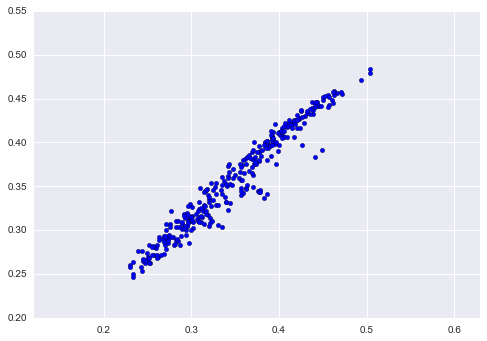

In [34]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)

X_pca = pca.transform(X)
X_new = pca.inverse_transform(X_pca)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=1.0)
plt.axis('equal');

In [35]:
# Split the dataset in two parts
from sklearn.cross_validation import train_test_split
#Se separa 80% para data train y 20% para Test. 
#Los datos se dividen en una forma estratificada, utilizando esto como las etiquetas de clase
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=49,stratify=y)



from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

#Logistic Regresion 
#param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
#clf_log = GridSearchCV(LogisticRegression(penalty='l2'), param_grid)
#clf_log.fit(X_train,y_train)
#print(clf_log.best_estimator_)
#print ('Mean accuracy - Logistic Regression: {0: .2f}%'.format(clf_log.best_score_*100))

#Decision Tree Classifier
tree = DecisionTreeClassifier()  #criterion = gini (default) - max_depth=None (default)
bagDT = BaggingClassifier(tree, n_estimators=500, max_samples=0.8,
                        random_state=1)

scores4 = cross_val_score(bagDT,X_train,y_train,cv=3)
print ("Cross Validation 3-fold - Mean score - Bagging para Decisión Tree Classifier(Sin poda)- Criterio: Gini = %0.2f (+/- %0.2f)" % (scores4.mean() * 100,scores4.std()))

bagDT.fit(X_train, y_train)

print ('Mean accuracy - Bagging para Decisión Tree Classifier(Sin poda)- Criterio: Gini (Test)= {0}%'.format(bagDT.score(X_test,y_test) * 100))

tree2 = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=None,
                              random_state=1)
bagDT2 = BaggingClassifier(base_estimator=tree2,
                        n_estimators=100, 
                        max_samples=1.0, 
                        max_features=1.0, 
                        bootstrap=True, 
                        bootstrap_features=False, 
                        n_jobs=1, 
                        random_state=1)

scores_tree2 = cross_val_score(bagDT2,X_train,y_train,cv=3)
print ("Cross Validation 3-fold - Mean score - Decisión Tree Classifier(Sin poda)- Criterio: Entropy = %0.2f (+/- %0.2f)" % (scores_tree2.mean() * 100, scores_tree2.std())) 

bagDT2.fit(X_train, y_train)
print ('Mean accuracy - Decisión Tree Classifier(Sin poda)- Criterio: Entropy (Test)= {0: .2f}%'.format(bagDT2.score(X_test,y_test) * 100))


#print('Mean accuracy -  Decisión Tree (Sin poda) = {0}%'.format(bagDT2.score(X_test,y_test) * 100)) 

#Para SVM con los mejores parámetros (Tomados del Paper)

svmRBF=svm.SVC(kernel='rbf',C=3.2,gamma=17.8)

scores3 = cross_val_score(svmRBF,X_train,y_train,cv=3)
#print(scores3)
print ("Cross Validation 3-fold - Mean score - SVM con mejores parametros del Paper  = %0.2f (+/- %0.2f)" % (scores3.mean()* 100,scores3.std()))
svmRBF.fit(X_train,y_train)
print ('Mean accuracy - SVM sin Bagging (Test)= {0}%'.format(svmRBF.score(X_test,y_test)* 100))
#print scores3

#svmRBF.fit(X_train, y_train)
#print 'Mean accuracy - SVM sin Bagging = {0}%'.format(svmRBF.score(X_test,y_test) * 100)
bagSVM = BaggingClassifier(base_estimator=svmRBF,
                        n_estimators=500, 
                        max_samples=1.0, 
                        max_features=1.0, 
                        bootstrap=True, 
                        bootstrap_features=False, 
                        n_jobs=3, 
                        random_state=1)
scores1 = cross_val_score(bagSVM,X_train,y_train,cv=3)
print ("Cross Validation 3-fold - Mean score - Bagging de SVM con mejores parametros = %0.2f (+/- %0.2f)" % (scores1.mean()* 100, scores1.std()))

bagSVM.fit(X_train, y_train)



from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=0)


scores2 = cross_val_score(model,X_train,y_train,cv=3)
print ("Cross Validation 3-fold - Mean score - RandomForest = %0.2f (+/- %0.2f)" % (scores2.mean()* 100,scores2.std()))

model.fit(X_train, y_train)
print ('Mean accuracy - RandomForest (Test) = {0}%'.format(model.score(X_test,y_test) * 100))

print ('\n')


print ('Mejor Modelo es Bagging de SVM :')

print ("Mean accuracy - Bagging de SVM (Test) - Accuracy = %0.2f" % (bagSVM.score(X_test,y_test) * 100)+'%')

Mean accuracy - Decisión Tree Classifier(Sin poda)- Criterio: Gini = 64.52 (+/- 0.03)
Mean accuracy - Bagging para Decisión Tree Classifier(Sin poda)- Criterio: Gini (Test)= 81.25%
Mean accuracy - Decisión Tree Classifier(Sin poda)- Criterio: Entropy = 65.21 (+/- 0.02)
Mean accuracy -  Decisión Tree Classifier(Sin poda)- Criterio: Entropy (Test)=  79.69%
Mean accuracy - SVM con mejores parametros del Paper  = 64.90 (+/- 0.02)
Mean accuracy - SVM sin Bagging = 79.6875%
Mean accuracy - Bagging de SVM con mejores parametros = 65.30 (+/- 0.03)
Mean accuracy - RandomForest = 63.35 (+/- 0.03)
Mean accuracy - RandomForest (Test) = 79.6875%


Mejor Modelo es Bagging de SVM :
Mean accuracy - Bagging de SVM (Test) - Accuracy = 81.25%


# Boosting para Arboles de Decisión de un nivel

In [36]:
from sklearn.ensemble import AdaBoostClassifier
tree3 = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=1,
                              random_state=0)

ada = AdaBoostClassifier(base_estimator=tree,
                         n_estimators=500, 
                         learning_rate=0.1,
                         random_state=0)

ada = ada.fit(X_train, y_train)
print 'Mean accuracy - DT con Boosting = {0}%'.format(ada.score(X_test,y_test) * 100)


#No se obtuvo buenos resultados en comparación al Bagging. 
#Aprevechamos que tenemos un strong classifier base SVM con los mejores parametros

Mean accuracy - DT con Boosting = 71.875%


# Redes Neuronales

In [42]:
rows = X.shape[0]
params = y.shape[0]

all_theta = np.zeros((10, params + 1))

X = np.insert(X, 0, values=np.ones(rows), axis=1)

theta = np.zeros(params + 1)

y_0 = np.array([1 if label == 0 else 0 for label in y])
y_0 = np.reshape(y_0, (rows, 1))

X.shape, y_0.shape, theta.shape, all_theta.shape

((320, 6), (320, 1), (321,), (10, 321))

In [43]:
np.unique(y)

array([ 0.,  1.,  2.,  3.])

In [44]:
all_theta = one_vs_all(X, y, 4, 0.005)
all_theta

array([[ 0.00284296,  0.00267684, -0.02135571, -0.0065372 , -0.00815585,
         0.02829482, -0.01202974],
       [ 0.0004902 ,  0.00048784,  0.00211984, -0.00310685,  0.01228771,
        -0.01449754, -0.002383  ],
       [-0.0086756 , -0.00833911,  0.02091454,  0.00167256, -0.01569244,
         0.02542789,  0.0069301 ],
       [-0.45915566, -0.45637732,  0.01394999, -0.01632217, -0.13594649,
        -0.10842938, -0.01234403]])

In [45]:
def predict_all(X, all_theta):
    rows = X.shape[0]
    params = X.shape[1]
    num_labels = all_theta.shape[0]
    
    # same as before, insert ones to match the shape
    X = np.insert(X, 0, values=np.ones(rows), axis=1)
    
    # convert to matrices
    X = np.matrix(X)
    all_theta = np.matrix(all_theta)
    
    # compute the class probability for each class on each training instance
    h = sigmoid(X * all_theta.T)
    
    # create array of the index with the maximum probability
    h_argmax = np.argmax(h, axis=1)
    
    # because our array was zero-indexed we need to add one for the true label prediction
    h_argmax = h_argmax + 1
    
    return h_argmax

In [46]:
y_pred = predict_all(X, all_theta)

#print y_pred
correct = [1 if a == b else 0 for (a, b) in zip(y_pred, y)]
accuracy = (sum(map(int, correct)) / float(len(correct)))
print ('accuracy = {0}%'.format(accuracy * 100))


accuracy = 53.75%


# Majority Vote Classifier

In [47]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator


class MajorityVoteClassifier(BaseEstimator, 
                             ClassifierMixin):
    """ A majority vote ensemble classifier

    Parameters
    ----------
    classifiers : array-like, shape = [n_classifiers]
      Different classifiers for the ensemble

    vote : str, {'classlabel', 'probability'} (default='label')
      If 'classlabel' the prediction is based on the argmax of
        class labels. Else if 'probability', the argmax of
        the sum of probabilities is used to predict the class label
        (recommended for calibrated classifiers).

    weights : array-like, shape = [n_classifiers], optional (default=None)
      If a list of `int` or `float` values are provided, the classifiers
      are weighted by importance; Uses uniform weights if `weights=None`.

    """
    def __init__(self, classifiers, vote='classlabel', weights=None):

        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """ Fit classifiers.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Matrix of training samples.

        y : array-like, shape = [n_samples]
            Vector of target class labels.

        Returns
        -------
        self : object

        """
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError("vote must be 'probability' or 'classlabel'"
                             "; got (vote=%r)"
                             % self.vote)

        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError('Number of classifiers and weights must be equal'
                             '; got %d weights, %d classifiers'
                             % (len(self.weights), len(self.classifiers)))

        # Use LabelEncoder to ensure class labels start with 0, which
        # is important for np.argmax call in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        """ Predict class labels for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Matrix of training samples.

        Returns
        ----------
        maj_vote : array-like, shape = [n_samples]
            Predicted class labels.
            
        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' vote

            #  Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers_]).T

            maj_vote = np.apply_along_axis(
                                      lambda x:
                                      np.argmax(np.bincount(x,
                                                weights=self.weights)),
                                      axis=1,
                                      arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        """ Predict class probabilities for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.

        Returns
        ----------
        avg_proba : array-like, shape = [n_samples, n_classes]
            Weighted average probability for each class per sample.

        """
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        """ Get classifier parameter names for GridSearch"""
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value
            return out

In [51]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
#if Version(sklearn_version) < '0.18':
from sklearn.cross_validation import train_test_split
#else:
#    from sklearn.model_selection import train_test_split

import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.pipeline import Pipeline
#if Version(sklearn_version) < '0.18':
from sklearn.cross_validation import cross_val_score
#else:
#    from sklearn.model_selection import cross_val_score



clf2 = DecisionTreeClassifier(max_depth=3,
                              criterion='entropy',
                              random_state=0)

clf3 = KNeighborsClassifier(n_neighbors=1,
                            p=2,
                            metric='minkowski')



#pipe1 = Pipeline([['sc', StandardScaler()],
#                  ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf3]])

#clf_labels = ['Logistic Regression', 'Decision Tree', 'KNN']



mv_clf = MajorityVoteClassifier(classifiers=[pipe3, bagDT2, svmRBF])


#print 'Mean accuracy - Majority Voting = {0}%'.format(mv_clf.score(X_test,y_test) * 100)


scores5 = cross_val_score(mv_clf,X_train,y_train,cv=3)
print 'Cross Validation 3-fold - Mean score - Majority Voting = {0: 0.2f}%'.format(scores5.mean()* 100)
print("\n")
mv_clf.fit(X_train,y_train)
y_pred= mv_clf.predict(X_test)
from sklearn import metrics
target_names = ['Airplane', 'Alarm clock', 'Angel', 'Ant']
print(metrics.classification_report(y_test, y_pred,target_names=target_names))
print ('Mean accuracy(con Data Test) - Majority Voting: {0}%'.format(metrics.accuracy_score(y_test, y_pred)*100))
print("\n")
print("Matríz de confusión")
print("\n")
cnf_matrix= metrics.confusion_matrix(y_test, y_pred, labels=[0.,1.,2.,3.])
print(cnf_matrix)

Mean accuracy - Majority Voting =  66.07%


             precision    recall  f1-score   support

   Airplane       0.74      0.88      0.80        16
Alarm clock       0.83      0.94      0.88        16
      Angel       0.92      0.75      0.83        16
        Ant       0.79      0.69      0.73        16

avg / total       0.82      0.81      0.81        64

Mean accuracy - Majority Voting: 81.25%


Matríz de confusión


[[14  0  0  2]
 [ 0 15  1  0]
 [ 1  2 12  1]
 [ 4  1  0 11]]


# Mostrando Métricas y Matríz de Confusión del Majority Voting

In [52]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization
[[14  0  0  2]
 [ 0 15  1  0]
 [ 1  2 12  1]
 [ 4  1  0 11]]


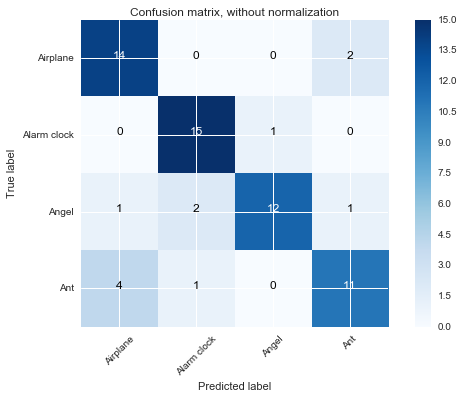

In [53]:
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Confusion matrix, without normalization')